# Uncertainty-Aware Road Obstacle Identification

In this notebook, we propose an implementation of Road Obstacle Identification architecture, with the addition of a certain threshold of confidence to uncertainty, thanks to a state-of-the-art approach to loss function computations, the so called "Boundary Aware Binary Cross Entropy". These are the main implemented topics:
- **Multilabel One-Hot Encoding**
- **DeepLabV3+ --> ResNet50**
- **Boundary Aware BCE**

## Import Necessary Libraries

In [1]:
import torch
#import sklearn
import os
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
import cv2
import numpy as np
import shutil
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
#import segmentation_models_pytorch as smp

In [2]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version PyTorch was built with: {torch.version.cuda}")
print(f"CUDA runtime version: {torch._C._cuda_getCompiledVersion()}")


PyTorch version: 2.7.0+cu126
Torchvision version: 0.22.0+cu126
CUDA available: True
CUDA version PyTorch was built with: 12.6
CUDA runtime version: 12060


## Globals

In [3]:
# Macro class index mapping
MACRO_CLASSES = {
    "road": 0,
    "flat": 1,
    "human": 2,
    "vehicle": 3,
    "construction": 4,
    "background": 5,
    "object": 6,  # auxiliary objectness channel
}

# Map from original label ID to (macro class or None, is_object)   [None is only for the poles and traffic signs and lights]
CLASS_MAPPING = {
    7: ("road", False), # road
    8: ("flat", False), # sidewalk
    11: ("construction", False), # building
    12: ("construction", False), # wall
    13: ("construction", False), # fence
    17: (None, True),  # pole
    19: (None, True),  # traffic sign
    20: (None, True),  # traffic light
    21: ("background", False), # vegetation
    22: ("flat", False), # terrain
    23: ("background", False), # sky
    24: ("human", True), # person
    25: ("human", True), # rider
    26: ("vehicle", True), # car
    27: ("vehicle", True), # truck
    28: ("vehicle", True), # bus
    31: ("vehicle", True), # train
    32: ("vehicle", True), # motorcycle
    33: ("vehicle", True), # bicycle
}

## Utils

### Preprocessing

**Fixing the Dataset**

Here is the function to fix the structure of the dataset, downloaded from the official CityScapes website linked in the README file, from its original form to a preferred one, following the structure defined therein

In [4]:
def fix_dataset(path_in, path_out, image_folder_in="leftImg8bit", mask_folder_in="gtFine", is_delete=False): # is_delete=True if you want to delete the city folders after copying
    """
    Fixes the dataset by renaming the files and removing the city folders.
    """
    splits = ['train', 'val', 'test']

   
    for split in splits:
        count = 1
        img_dir = os.path.join(path_in, image_folder_in, split)
        mask_dir = os.path.join(path_in, mask_folder_in, split)

        # New destination directories
        img_out = os.path.join(path_out, 'img', split)
        mask_out = os.path.join(path_out, 'mask', split)
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(mask_out, exist_ok=True)

        # Iterate on sub-folders
        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            city_mask_dir = os.path.join(mask_dir, city)

            if not os.path.isdir(city_img_dir):
                continue  # Skips non-directory files

            for filename in os.listdir(city_img_dir):
                if not filename.endswith('leftImg8bit.png'):
                    continue
                img_path = os.path.join(city_img_dir, filename)
                base_prefix = filename.replace('_leftImg8bit.png', '')

                # Renames and copies RGB
                new_base = f"{split}{count}"
                ext = '.png'
                new_img_name = f"{new_base}{ext}"
                shutil.copy(img_path, os.path.join(img_out, new_img_name))


                if split != 'test': # For test split, we only copy the image
                    
                    # Renames and copies all 'label' associated files
                    suffixes = ['_gtFine_labelIds.png', '_gtFine_color.png', '_gtFine_instanceIds.png', '_gtFine_polygons.json']
                    for suffix in suffixes:
                        if suffix == '_gtFine_labelIds.png':
                            original_name = base_prefix + suffix
                            source = os.path.join(city_mask_dir, original_name)
                            if os.path.exists(source):
                                new_name = f"{new_base}_m.png"  # es. train1_mask.png
                                shutil.copy(source, os.path.join(mask_out, new_name))
                        else:
                            continue

                count += 1
                    
            if is_delete:        
                # Cleans city folders if empty
                if os.path.isdir(city_img_dir) and not os.listdir(city_img_dir):
                    os.rmdir(city_img_dir)
                if os.path.isdir(city_mask_dir) and not os.listdir(city_mask_dir):
                    os.rmdir(city_mask_dir)

                # Removes split folders if empty
                for d in [img_dir, mask_dir]:
                    if os.path.isdir(d) and not os.listdir(d):
                        os.rmdir(d)



is_fixed = True
if not is_fixed:
    print("Fixing dataset...")
    # Fix the dataset
    fix_dataset('../../datasets', '../../cityscapes_f')

**Converting Data**

With these functions, we convert labels and images from the dataset into PyTorch tensors, in order to feed them to the network and begin the training process

In [4]:
# Prepare a mapping from original labels to macro class index (0 to 6)
# For original labels mapped to None macro class (like poles, signs, lights), only 'object' class (6) will be set.

LABEL_TO_MACRO_IDX = {}

for original_id, (macro_class, is_object) in CLASS_MAPPING.items():
    if macro_class is not None:
        LABEL_TO_MACRO_IDX[original_id] = MACRO_CLASSES[macro_class]
    else:
        # For None macro class, we don't assign a macro_idx (only object channel will be set)
        LABEL_TO_MACRO_IDX[original_id] = None


def convert_label_to_multilabel_one_hot(label: torch.Tensor) -> torch.Tensor:
    """
    Converts 2D label mask [H, W] with Cityscapes original IDs into a multi-label one-hot encoding tensor [7, H, W].
    The last channel (index 6) corresponds to the 'object' auxiliary channel.
    """

    # Get the spatial dimensions of the label mask
    height, width = label.shape

    # Initialize the output tensor with 7 channels (macro-classes), filled with zeros.
    # Each channel corresponds to a macro-class.
    multilabel = torch.zeros((7, height, width), dtype=torch.float32)

    # Iterate over each original class ID defined in the CLASS_MAPPING
    for original_id, (_, is_object) in CLASS_MAPPING.items():

        # Create a boolean mask of where the input label equals the current original class ID
        mask = (label == original_id)

        # Look up the macro-class index for this class ID, or None if it doesn't belong to any
        macro_idx = LABEL_TO_MACRO_IDX[original_id]

        # If this class maps to a macro-class, set 1 at those pixel locations in the corresponding channel
        if macro_idx is not None:
            multilabel[macro_idx][mask] = 1.0  # Set the macro-class channel to 1 where the mask is True

        # If this class is considered an 'object', also set the 'object' channel (index 6) to 1
        if is_object:
            multilabel[MACRO_CLASSES["object"]][mask] = 1.0  # Set the object class channel to 1

    # Return the resulting multi-label one-hot tensor of shape [7, H, W]
    return multilabel



**Boundaries Detection**

Here we compute the boundary mask on the ground truth segmentation labels, to tell the model “this is a boundary region, pay more attention here”.

To do that we use morphological gradient (difference between the dilation and the erosion of the image):
- **Dilation**: expand the region of each class, boundary pixels move away from the center of the region (each pixel replaced with maximum value in its neighborhood)
- **Erosion**: reduce the region of each class, boundary pixels move toward the center of the region (each pixel replaced with minimum value in its neighborhood)

In [6]:
def get_boundary_mask(label_mask, kernel_size=3):
    """
    Computes the boundary mask from a label mask using morphological operations.
    Args:
        label_mask (numpy.ndarray): Input label mask with shape [H, W].
        kernel_size (int): Size of the kernel for morphological operations.
    Returns:
        numpy.ndarray: Boundary mask with shape [H, W].
    """
    
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(label_mask, kernel, iterations=2)
    eroded = cv2.erode(label_mask, kernel, iterations=2)
    boundary = (dilated != eroded).astype(np.uint8)
    return boundary

To process multiple masks in parallel:

In [5]:
import torch
import torch.nn.functional as F

def get_boundary_mask_batch(label_masks, kernel_size=3, iterations=2):
    """
    Computes the boundary mask for a batch of label masks using morphological operations.
    Args:
        label_masks (torch.Tensor): Tensor of shape [B, H, W] or [B, 1, H, W], with binary masks (0 or 1).
        kernel_size (int): Size of the kernel for morphological operations.
        iterations (int): Number of times to apply dilation and erosion.
    Returns:
        torch.Tensor: Boundary masks of shape [B, H, W], dtype=torch.uint8.
    """

    if label_masks.dim() == 3:
        label_masks = label_masks.unsqueeze(1)  # [B, 1, H, W]

    # Ensure float type for convolution
    label_masks = label_masks.float()

    # Define kernel (morphological structuring element)
    device = label_masks.device
    kernel = torch.ones((1, 1, kernel_size, kernel_size), device=device)

    padding = kernel_size // 2

    # Apply dilation
    dilated = label_masks
    for _ in range(iterations):
        dilated = F.conv2d(dilated, kernel, padding=padding)
        dilated = (dilated > 0).float()

    # Apply erosion
    eroded = label_masks
    for _ in range(iterations):
        eroded = F.conv2d(eroded, kernel, padding=padding)
        eroded = (eroded == kernel.numel()).float()

    # Compute boundary: difference between dilated and eroded regions
    boundary = (dilated != eroded).float()

    return boundary.squeeze(1).byte()  # Return shape [B, H, W], uint8


### Visualization

Some functions to show the aforementioned preprocessing, useful to visualize the data we are working with

In [12]:
class_names_7 = ["road", "flat", "human", "vehicle", "construction", "background", "object"]

def visualize_one_hot_vertical(one_hot, class_names=None, max_classes=7):
    """
    Visualizes the one-hot encoded masks vertically.
    """
    num_classes = min(one_hot.shape[0], max_classes)
    fig, axes = plt.subplots(num_classes, 1, figsize=(5, 3 * num_classes))

    for i in range(num_classes):
        ax = axes[i]
        ax.imshow(one_hot[i], cmap='gray')
        title = f"Class {i}" if class_names is None else class_names[i]
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def visualize_erosion_mask(label_mask):
    """
    Visualizes the erosion mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(erosion, cmap='gray')
    plt.title("Erosion Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_dilation_mask(label_mask):
    """
    Visualizes the dilation mask of a label mask.
    """
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(label_mask, kernel, iterations=2)
    plt.figure()
    plt.imshow(dilation, cmap='gray')
    plt.title("Dilation Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_boundary_mask(label_mask):
    """
    Visualizes the boundary mask.
    """
    boundary = get_boundary_mask(label_mask)
    plt.figure()
    plt.imshow(boundary, cmap='gray')
    plt.title("Boundary Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Data

In [7]:
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
from torchvision import transforms as T


# Define the transformation for images
##############

resized_height = 512
resized_width = 1024


transform = T.Compose([
    T.Resize((resized_height, resized_width)),  # Resize to half the original size
    T.ToTensor(),  # converts in [0, 1], shape [3, H, W]
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

#############

class CityscapesTrainEvalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=transform):
        self.transform = transform 
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)

        # Collect all image paths
        self.img_paths = list(self.img_dir.rglob("*.png"))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # Derive corresponding mask path by adding '_m' before the extension
        mask_name = img_path.stem + "_m.png"
        mask_path = self.mask_dir / mask_name

        if not mask_path.exists():
            print(f"Warning: No mask found for image: {img_path.name}")

        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        # Load and preprocess mask
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale (single channel)

        # Resize mask with nearest neighbor interpolation
        resized_mask = mask.resize((resized_width, resized_height), resample=Image.NEAREST)

        mask_np = np.array(resized_mask, dtype=np.uint8)

        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)

        mask_onehot = convert_label_to_multilabel_one_hot(mask_tensor)
        

        return img, mask_onehot, mask_np




class CityscapesTestDataset(Dataset):
    def __init__(self, img_dir, transform=transform):
        self.img_paths = sorted(Path(img_dir).rglob("*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        return img, str(img_path.name)  # Return the filename for later use


In [9]:
# Set the relative path for the dataset

relative_path = '../../'

In [17]:
train_set = CityscapesTrainEvalDataset(relative_path + 'cityscapes_f/img/train', relative_path + 'cityscapes_f/mask/train')
val_set = CityscapesTrainEvalDataset(relative_path + 'cityscapes_f/img/val', relative_path + 'cityscapes_f/mask/val')
test_set = CityscapesTestDataset(relative_path + 'cityscapes_f/img/test')

batch_size = 4

#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=True) # drop_last=True to ensure all batches have the same size
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
#test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

for imgs, masks, original_mask in val_loader:
    print("Batch of images shape:", imgs.shape)  # Should be [B, 3, H, W]
    print("Batch of masks shape:", masks.shape)  # Should be [B, 7, H, W]
    print("Original mask shape:", original_mask.shape)  # Should be [B, H, W]
    break  # Just to check the first batch

Batch of images shape: torch.Size([4, 3, 512, 1024])
Batch of masks shape: torch.Size([4, 7, 512, 1024])
Original mask shape: torch.Size([4, 512, 1024])


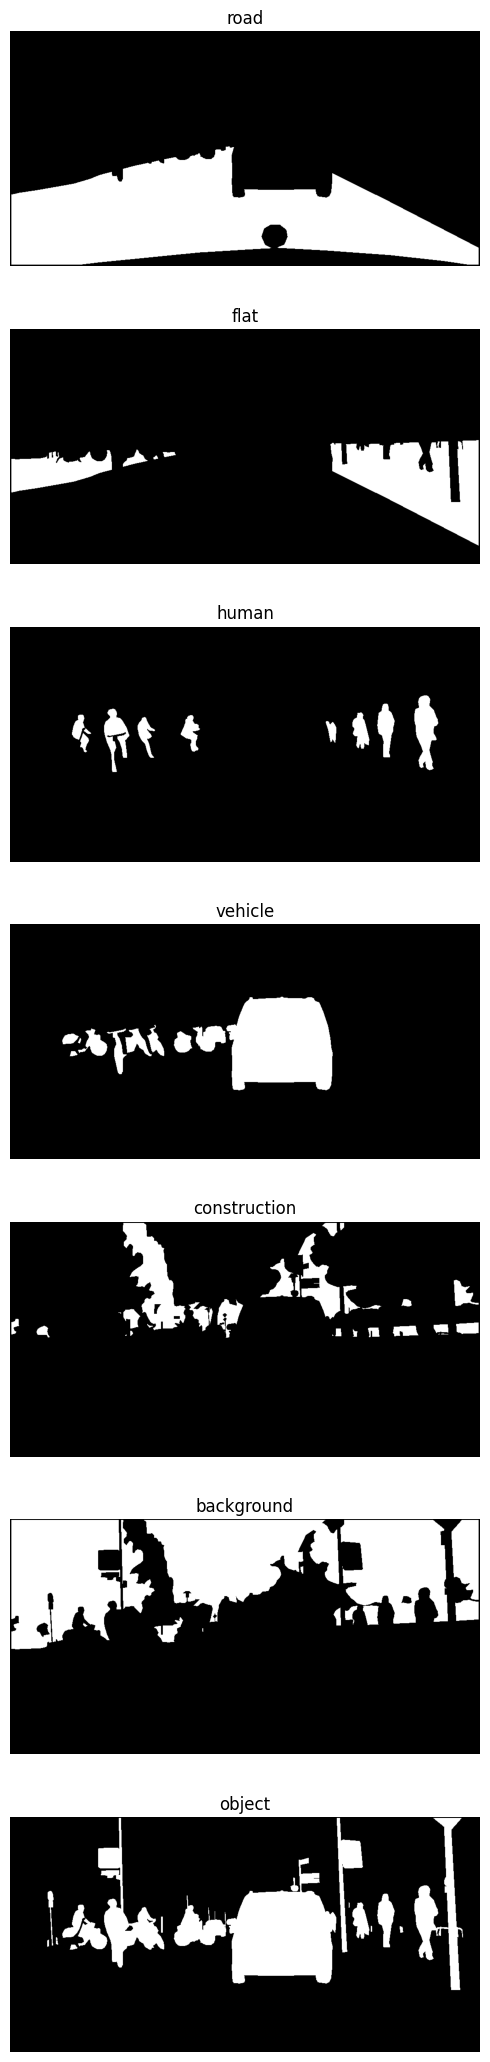

In [14]:
visualize_one_hot_vertical(masks[1], class_names=class_names_7)

## Network

In [15]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

class MultiLabelDeepLabV3(nn.Module):
    def __init__(self, n_classes=7):
        super().__init__()
        # Load pretrained model
        self.model = deeplabv3_resnet50(pretrained=True)
        
        # Replace classifier to output 7 channels with sigmoid
        self.model.classifier[-1] = nn.Conv2d(
            in_channels=256,
            out_channels=n_classes,
            kernel_size=1
        )
    
    def forward(self, x):
        x = self.model(x)['out']
        return torch.sigmoid(x)  # Apply sigmoid for multilabel outputs


### Loss Function

**Boundary Aware BCE**

Following the format of how to create a custom loss function according to:
https://medium.com/we-talk-data/crafting-custom-loss-functions-in-pytorch-an-advanced-guide-830ff717163e

- lambda_weight: weight lambda of the formula
- pred: tensor of the outputs of the sigmoid head, the dimension is (B, C, H, W) with B batch size, C classes ...
- target: ground truth one hot encoded with dimension (B, C, H, W)
- boundary_mask: mask computed using get_boundary_mask() where 1 indicates boundary pixel, dimension (B, 1, H, W)

In [16]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        #to avoid log(0)
        eps = 1e-7

        #standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
        normal_term = bce.mean()

        boundary_mask = boundary_mask.float()
        #expansion to (B, C, H, W) to do the multiplication

        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)
            
        boundary_mask = boundary_mask.expand(-1, pred.shape[1], -1, -1)

        #boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        num_boundary_pixels = boundary_mask.sum(dim=(1, 2, 3)).clamp(min=1.0) #boundary pixels of each image
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

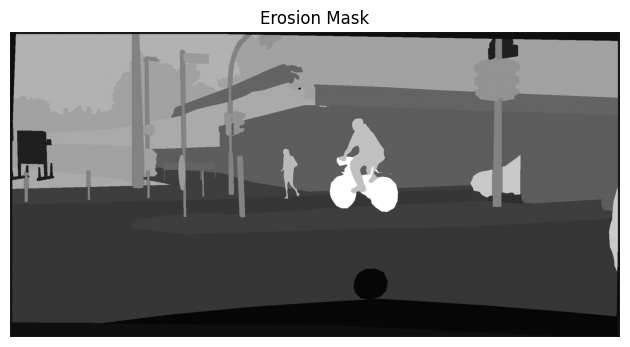

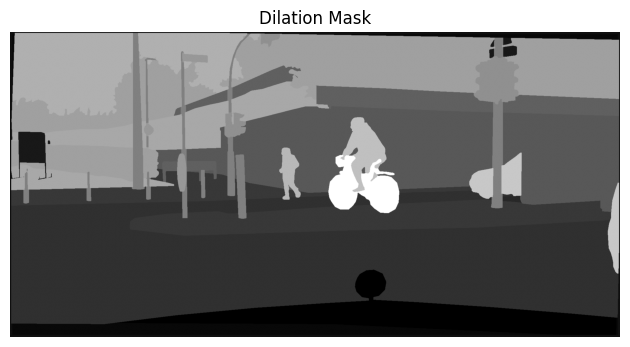

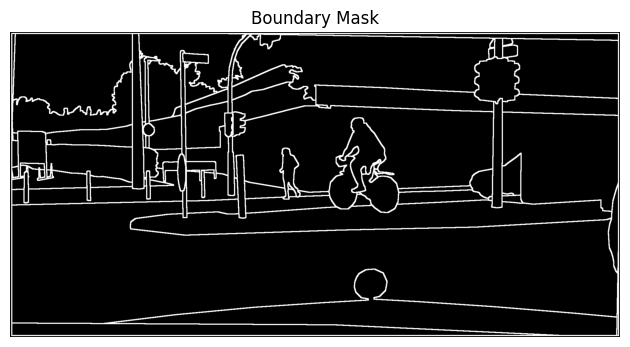

In [16]:
visualize_erosion_mask(np.array(Image.open('../../cityscapes_f/mask/train/train1_m.png')))
visualize_dilation_mask(np.array(Image.open('../../cityscapes_f/mask/train/train1_m.png')))
visualize_boundary_mask(np.array(Image.open('../../cityscapes_f/mask/train/train1_m.png')))

## Train

In [17]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiLabelDeepLabV3(n_classes=7).to(device)
criterion = BoundaryAwareBCELoss(lambda_weight=3.0)

# Parameters
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
num_epochs = 1

optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)

# Calculate max iterations for poly schedule
max_iter = num_epochs * len(train_loader)
current_iter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        preds = model(imgs)

        boundary_masks = get_boundary_mask_batch(original_mask)

        boundary_masks = boundary_masks.to(device)
        
        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Update learning rate using poly policy
        current_iter += 1
        lr = initial_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, LR: {lr:.6f}")


/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 743/743 [07:54<00:00,  1.57it/s]

Epoch [1/1], Loss: 0.3560, LR: 0.000000


In [20]:
# Save the model's state_dict
torch.save(model.state_dict(), "model_weights.pth")

## Test

In [18]:
# Recreate the model architecture
model = MultiLabelDeepLabV3(n_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = BoundaryAwareBCELoss(lambda_weight=3.0)
model.to(device)  # move to GPU or CPU as appropriate

# Load saved weights
model.load_state_dict(torch.load("model_weights.pth", map_location=device))

model.eval()  # Set model to evaluation mode

total_loss = 0.0
with torch.no_grad():
    for batch_idx, (imgs, masks, original_mask) in enumerate(tqdm(val_loader, desc="Validation")):  # Assume val_loader is your validation DataLoader
        imgs, masks = imgs.to(device), masks.to(device)
        
        preds = model(imgs)
        
        # Compute boundary masks for the ground truth masks
        boundary_masks = get_boundary_mask_batch(original_mask)  # Ensure this returns tensor on device

        boundary_masks = boundary_masks.to(device)
        
        loss = criterion(preds, masks, boundary_masks)
        total_loss += loss.item()

        # Save each prediction tensor as .pt file
        for i in range(preds.shape[0]):
            pred_tensor = preds[i].cpu()  # Move to CPU
            filename = os.path.join("saved_predictions/", f"image_{batch_idx * preds.shape[0] + 1 + i}.pt")
            torch.save(pred_tensor, filename)
        
        if batch_idx > 10:  # Print first 10 predictions for debugging
            break

avg_loss = total_loss / len(val_loader)
print(f"Validation Loss: {avg_loss:.4f}")


/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation:   9%|▉         | 11/125 [00:05<00:53,  2.11it/s]

Validation Loss: 0.0236


## Evaluation Metrics

### 1. Pixel Accuracy

In [22]:
#Measures the percentage of correctly predicted pixels.

def pixel_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == targets).float()
    return correct.mean().item()


### 2. Per-Class IoU (Intersection over Union)

In [23]:
# Measures overlap between predicted and true regions per class.

def iou_per_class(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    ious = []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        intersection = (pred_cls * target_cls).sum(dim=(1, 2))
        union = (pred_cls + target_cls - pred_cls * target_cls).sum(dim=(1, 2))
        iou = (intersection + eps) / (union + eps)
        ious.append(iou.mean().item())
    return ious


### 3. Mean IOUs

In [24]:
# Average of IoUs over all classes.

def mean_iou(preds, targets, threshold=0.5):
    per_class_iou = iou_per_class(preds, targets, threshold)
    return sum(per_class_iou) / len(per_class_iou)


### 4. Dice Coefficient (F1 Score)

In [25]:
# Also called the Sørensen-Dice index, especially used for imbalanced segmentation.

def dice_score(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    scores = []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        intersection = (pred_cls * target_cls).sum(dim=(1, 2))
        union = pred_cls.sum(dim=(1, 2)) + target_cls.sum(dim=(1, 2))
        dice = (2 * intersection + eps) / (union + eps)
        scores.append(dice.mean().item())
    return scores


### 5. Precision and Recall per Class

In [26]:
def precision_recall(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    precisions, recalls = [], []
    for cls in range(preds.shape[1]):
        pred_cls = preds[:, cls]
        target_cls = targets[:, cls]
        tp = (pred_cls * target_cls).sum(dim=(1, 2))
        fp = (pred_cls * (1 - target_cls)).sum(dim=(1, 2))
        fn = ((1 - pred_cls) * target_cls).sum(dim=(1, 2))
        precision = (tp + eps) / (tp + fp + eps)
        recall = (tp + eps) / (tp + fn + eps)
        precisions.append(precision.mean().item())
        recalls.append(recall.mean().item())
    return precisions, recalls


###  Suggested Usage (after inference loop):

In [28]:
imgs, masks, original_mask = next(iter(val_loader))  # Get a batch from the validation set

imgs = imgs.to(device)

preds = (model(imgs))  # if output is logits
preds = preds.detach().cpu()
masks = masks.cpu()

print("Pixel Accuracy:", pixel_accuracy(preds, masks))
print("Mean IoU:", mean_iou(preds, masks))
print("Dice per class:", dice_score(preds, masks))
prec, rec = precision_recall(preds, masks)
print("Precision per class:", prec)
print("Recall per class:", rec)

Pixel Accuracy: 0.9844103455543518
Mean IoU: 0.8131335037095206
Dice per class: [0.9657183885574341, 0.9165440201759338, 0.5592986345291138, 0.9549679756164551, 0.8696110248565674, 0.9287185072898865, 0.927035391330719]
Precision per class: [0.9483600854873657, 0.9601550102233887, 0.8359928727149963, 0.9455663561820984, 0.9011904001235962, 0.9355578422546387, 0.9512099623680115]
Recall per class: [0.98429274559021, 0.8779958486557007, 0.5441602468490601, 0.9646557569503784, 0.8496416211128235, 0.9228422045707703, 0.9051734209060669]
